In [1]:
from importlib import reload
import os

import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader

# %load_ext tensorboard

from smlm_dl import dataset, loss, model, trainer, config, util
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


d:\github\smlm-dl\smlm_dl\dataset.py:423: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


219:	 [id = 219.000,], [A = 1788.302,], [bg = 57.541,], [x = -1.521,], [y = 9.308,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
235:	 [id = 235.000,], [A = 1328.539,], [bg = 79.657,], [x = 9.907,], [y = -6.235,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
111:	 [id = 111.000,], [A = 1772.879,], [bg = 48.357,], [x = -8.895,], [y = 6.031,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
30:	 [id = 30.000,], [A = 1948.712,], [bg = 57.470,], [x = -9.775,], [y = -4.851,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
99:	 [id = 99.000,], [A = 1900.765,], [bg = 25.480,], [x = 9.871,], [y = -0.877,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
117:	 [id = 117.000,], [A = 1457.436,], [bg = 66.986,], [x = 6.289,], [y = 1.737,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
225:	 [id = 225.000,], [A = 532.421,], [bg = 30.884,], [x = 9.692,], [y = -10.364,], [z = 0.000,], [sig_x = 5.000,], [sig_y = 5.000,],
24:	 [id = 24.000,], [A = 843.704,], [bg = 26.815,], [x = -

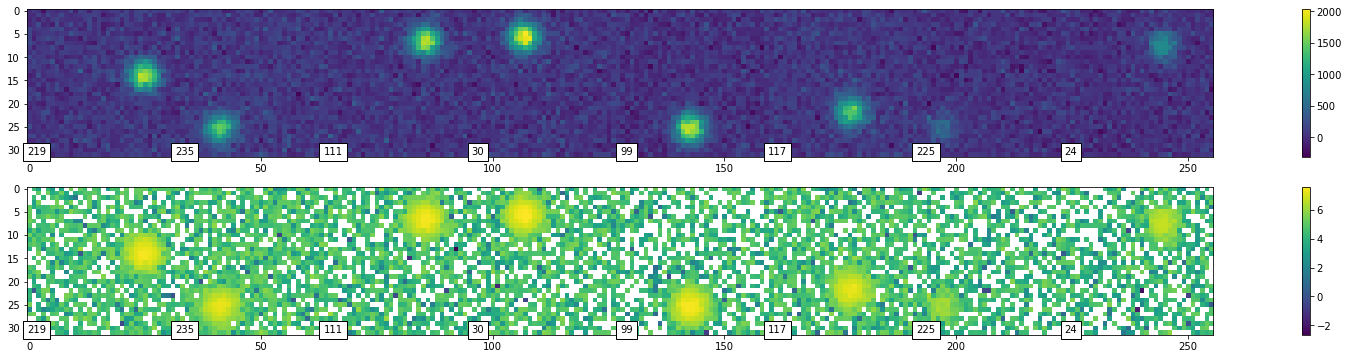

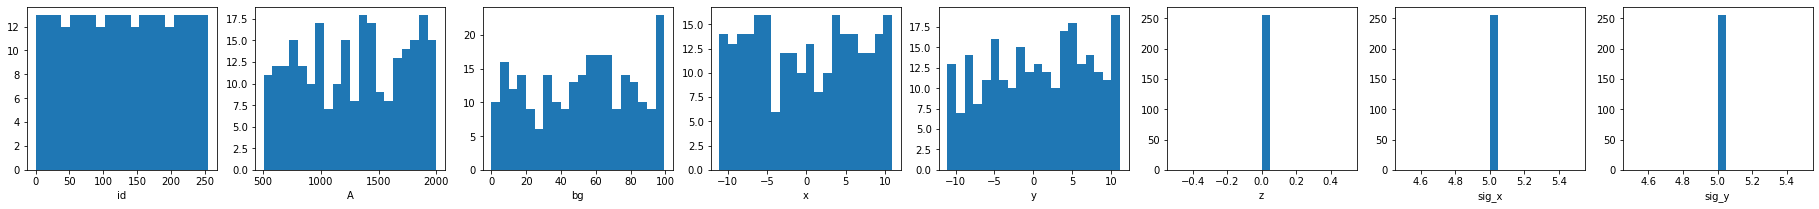

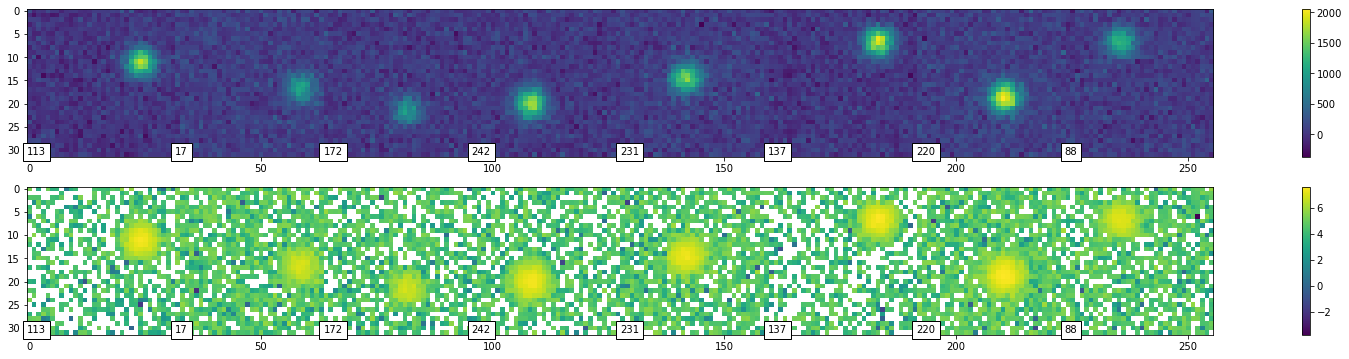

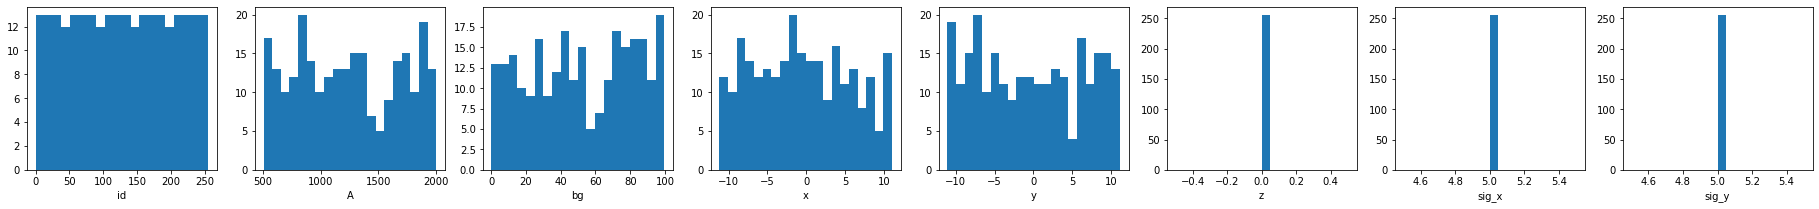

In [2]:
reload(dataset)

settings = {
    # 'out_size': (64,64),
    'length': (256, 1),
    'dropout_p': 0,
    # 'psf_params': {'z':[-10,10]},
    # 'psf_params': {'A':[200, 500], 'bg':[0, 0]},
    # 'psf_zerns': psf_zerns,
    'noise_params': {'poisson': True, 'gaussian': 100},
    # 'normalize': False,
    # 'padding': (4,4),
    # 'random_z': True,
    # "augmentations":{},
    # "augmentations":{"pixel shift":(4,4), }#"add noise":0.1},
    
}

training_data = dataset.Gaussian2DPSFDataset(**settings)
dataset.inspect_images(training_data)
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)

valid_data = dataset.Gaussian2DPSFDataset(**settings)
dataset.inspect_images(valid_data)
valid_dataloader = DataLoader(valid_data, batch_size=256, shuffle=True)

['x', 'y', 'A', 'sig', 'bg']


C:\Users\Kenny\anaconda3\envs\smlm-dl\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Layer (type (var_name))                       Output Shape              Param #
Gaussian2DModel                               --                        --
├─ConvImageEncoderModel (encoder)             [128, 5, 1, 1]            --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [128, 16, 16, 16]         --
│    │    │    └─Conv2d (0)                   [128, 16, 32, 32]         160
│    │    │    └─GELU (1)                     [128, 16, 32, 32]         --
│    │    │    └─Conv2d (2)                   [128, 16, 32, 32]         2,320
│    │    │    └─GELU (3)                     [128, 16, 32, 32]         --
│    │    │    └─MaxPool2d (4)                [128, 16, 16, 16]         --
│    │    │    └─Dropout2d (5)                [128, 16, 16, 16]         --
│    │    └─Sequential (conv_layer1)          [128, 32, 8, 8]           --
│    │    │    └─Conv2d (0)                   [128, 32, 16, 16]         4,640
│    │    │  

d:\github\smlm-dl\smlm_dl\model\base.py:145: RuntimeWarning: invalid value encountered in log10
  im = axes[0, i].imshow(np.log10(img))


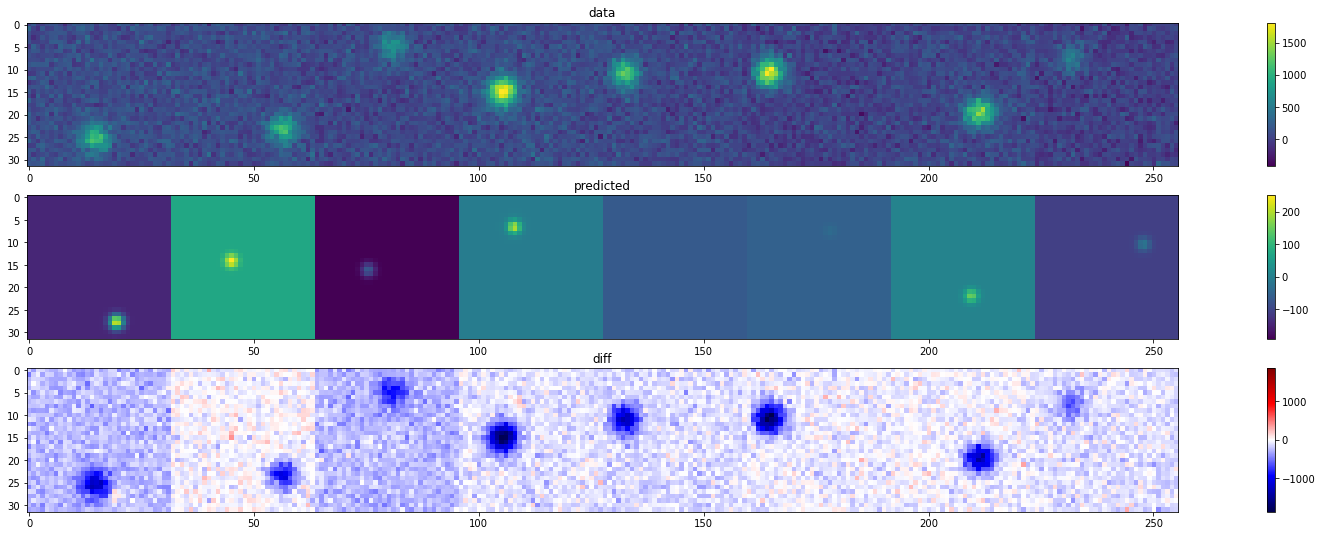

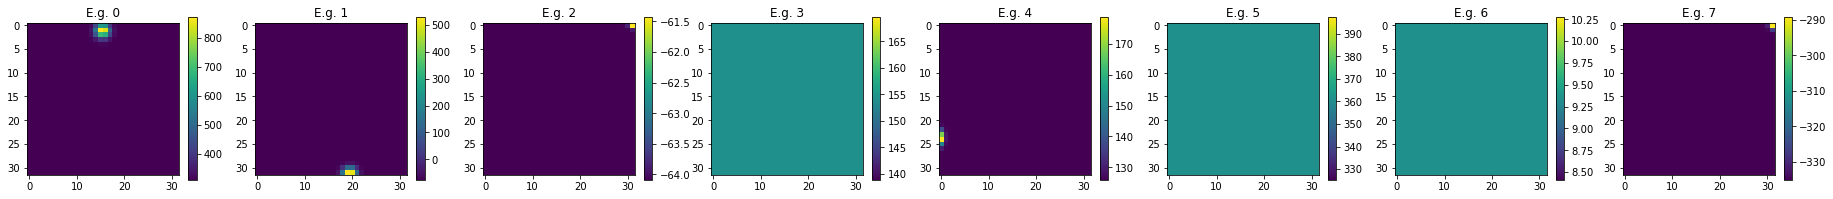

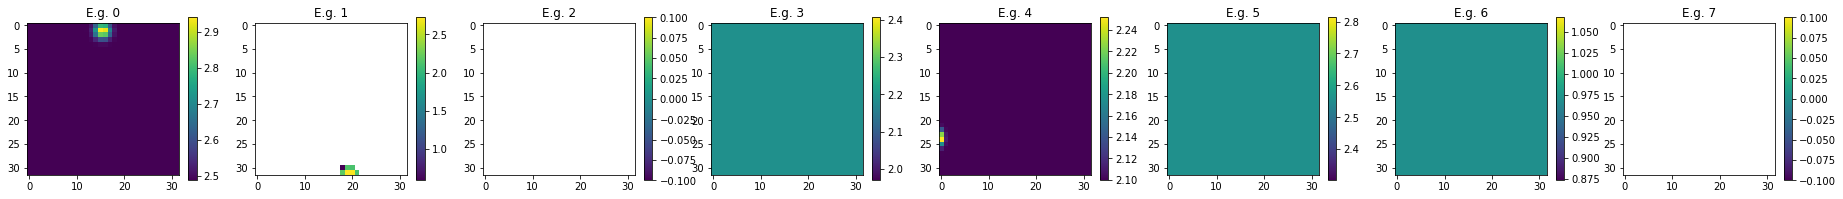

In [3]:
reload(model)

fitting_model = model.Gaussian2DModel(
                                      # img_size=(32,32),
                                      fit_params=['x','y','A','sig','bg'],
                                      max_psf_count=1,
                                      encoder_params={
                                          # "depth":3,
                                                      # "skip_channels":4,
                                                      # "first_layer_out_channels":16,
                                                     }
                                     )

print(fitting_model.fit_params)


print(summary(fitting_model, input_size=(128,1,32,32), row_settings=["var_names"], depth=4))

model.check_model(fitting_model, train_dataloader)

In [4]:
reload(loss)

<module 'smlm_dl.loss' from 'd:\\github\\smlm-dl\\smlm_dl\\loss.py'>

In [5]:
# loss_func = loss.GaussMLECameraLoss(gain=1, offset=0, var=100*2)
# optim_func = torch.optim.AdamW(fitting_model.parameters(), lr=1e-4)

# training = trainer.FittingTrainer(fitting_model, train_dataloader, optimizer=optim_func, loss_function=loss_func)
# training.train_and_validate(100000, 10, 100)

In [6]:
loss_func = loss.GaussPoissonMLECameraLoss(gain=1, offset=0, var=100**2, debug=True)
optim_func = torch.optim.AdamW(fitting_model.parameters(), lr=2e-5)

# training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, loss_function=loss_func)
training = trainer.FittingTrainer(fitting_model, train_dataloader, None, optimizer=optim_func, loss_function=loss_func)
training.train_and_validate(2, 10, 100)

No validation data supplied. Remember to set prior to training.
CUDA not available. Defaulting to CPU
Device: cpu
Saved to : D:\Pytorch\runs\2022-04-06_20-16-24_DESKTOP-7NNT713\model.ptm


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

poisson nll tensor(0., grad_fn=<SelectBackward0>) tensor(0., grad_fn=<SelectBackward0>)
gaussian nll tensor(5.1097, grad_fn=<SelectBackward0>) 0.9189385332046727
noises tensor(0., grad_fn=<SelectBackward0>) tensor(100.4565, grad_fn=<SubBackward0>) tensor(100.4565)
p tensor(0., grad_fn=<DivBackward0>)
poisson nll tensor(0., grad_fn=<SelectBackward0>) tensor(0., grad_fn=<SelectBackward0>)
gaussian nll tensor(5.1097, grad_fn=<SelectBackward0>) 0.9189385332046727
noises tensor(0., grad_fn=<SelectBackward0>) tensor(100.4565, grad_fn=<SubBackward0>) tensor(100.4565)
p tensor(0., grad_fn=<DivBackward0>)
poisson nll tensor(0., grad_fn=<SelectBackward0>) tensor(0., grad_fn=<SelectBackward0>)
gaussian nll tensor(5.1097, grad_fn=<SelectBackward0>) 0.9189385332046727
noises tensor(0., grad_fn=<SelectBackward0>) tensor(100.4565, grad_fn=<SubBackward0>) tensor(100.4565)
p tensor(0., grad_fn=<DivBackward0>)
poisson nll tensor(0., grad_fn=<SelectBackward0>) tensor(0., grad_fn=<SelectBackward0>)
gaussi

dict_keys(['poisson_nll_a', 'poisson_nll_b', 'gaussian_nll_a', 'gaussian_nll_b', 'input', 'target', 'poisson_noise', 'gaussian_noise', 'nll'])


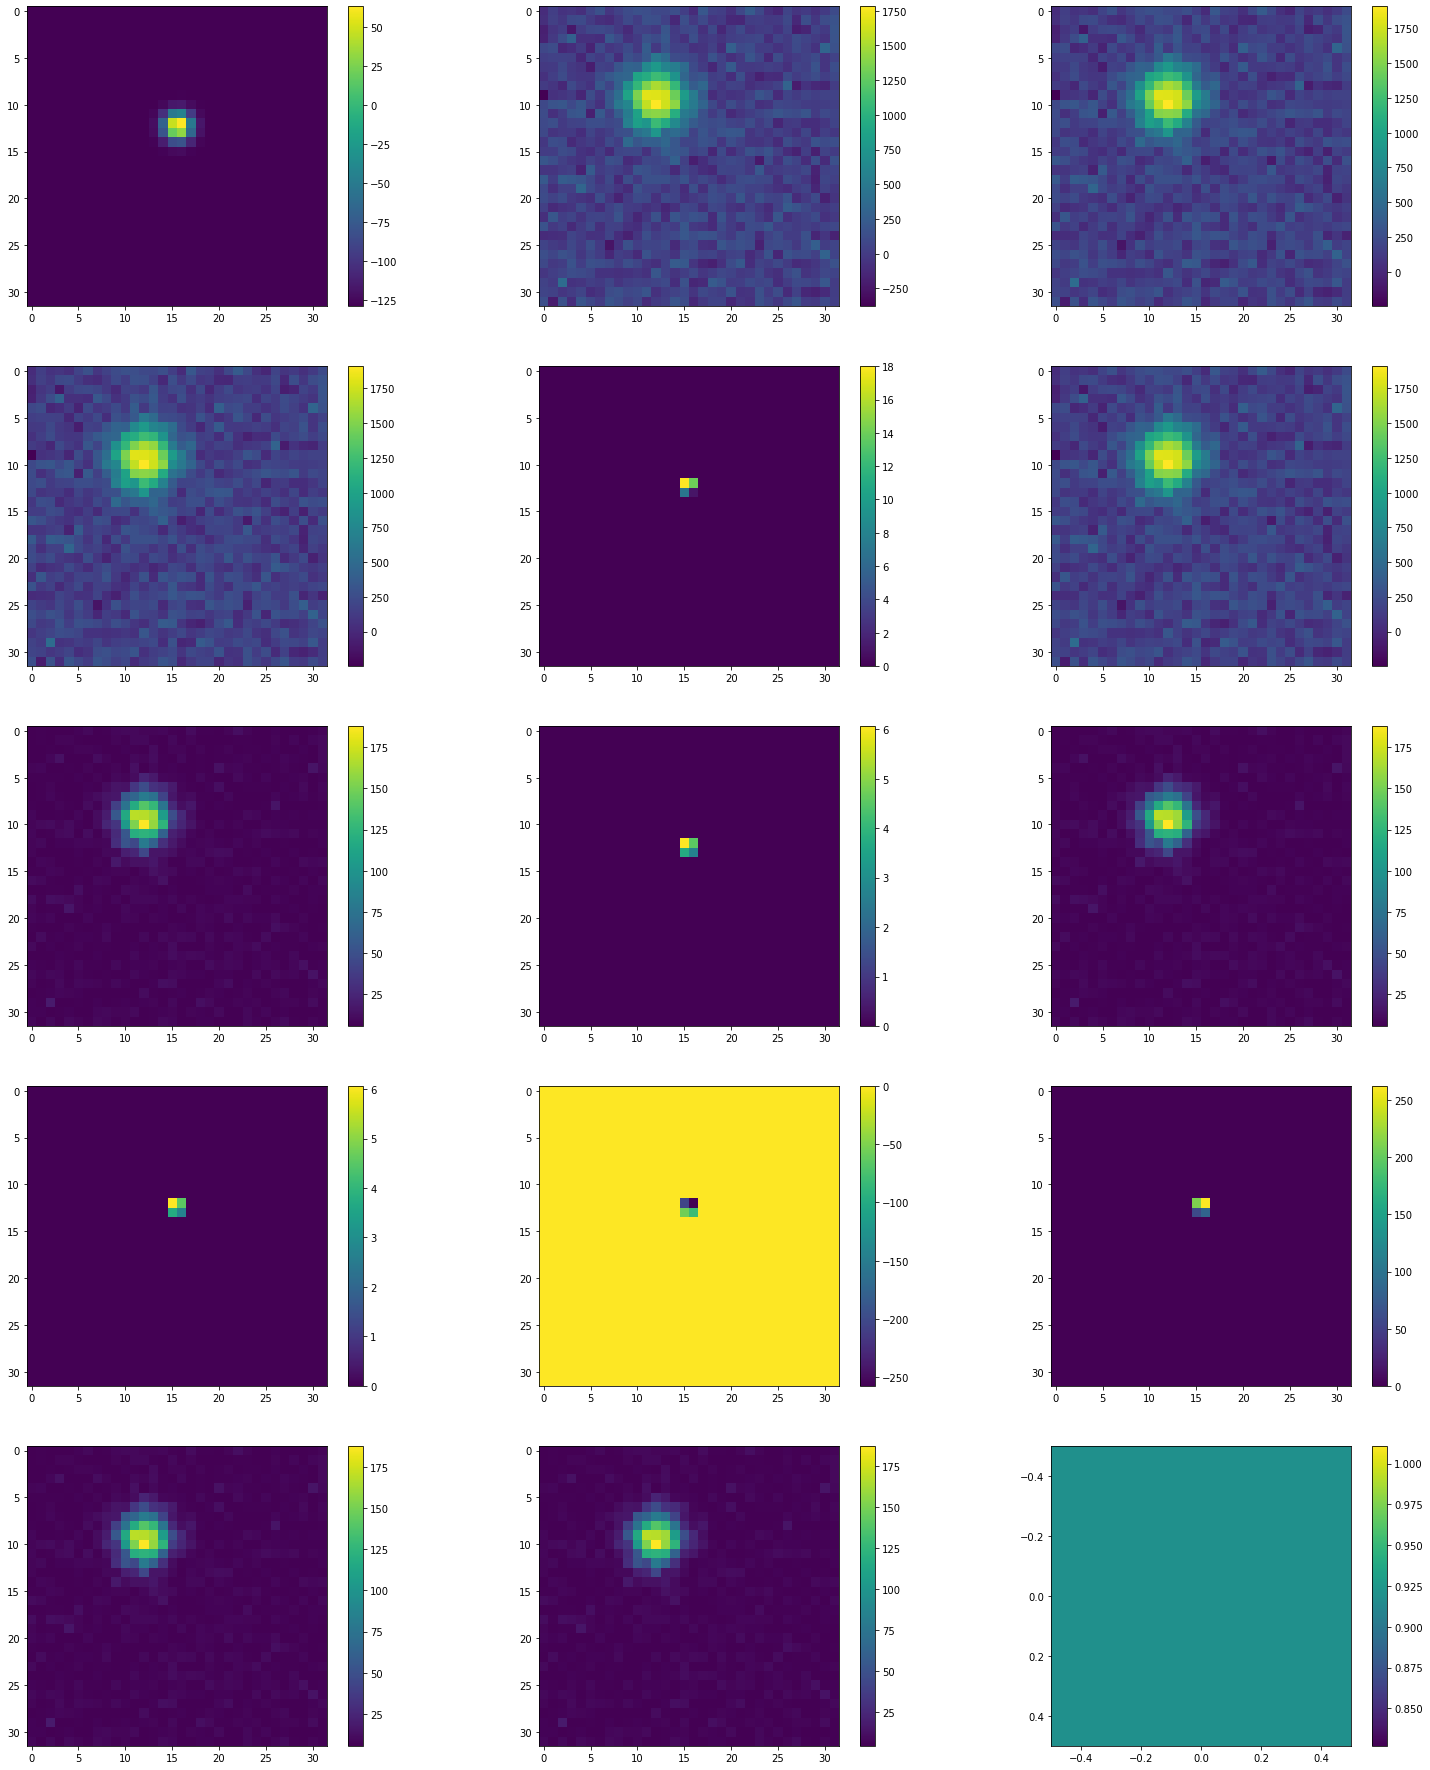

In [7]:
print(training.loss_function.cached_images.keys())
fig, axes = subplots(5, 3, figsize=(26,32))

im = axes[0,0].imshow(training.loss_function.cached_images["input"][0,0])
colorbar(im, ax=axes[0,0])
im = axes[0,1].imshow(training.loss_function.cached_images["target"][0,0])
colorbar(im, ax=axes[0,1])
im = axes[0,2].imshow(training.loss_function.cached_images["target"][0,0] - training.loss_function.cached_images["input"][0,0])
colorbar(im, ax=axes[0,2])

im = axes[1,0].imshow(training.loss_function.cached_images["poisson_noise"][0,0] + training.loss_function.cached_images["gaussian_noise"][0,0])
colorbar(im, ax=axes[1,0])
im = axes[1,1].imshow(training.loss_function.cached_images["poisson_noise"][0,0])
colorbar(im, ax=axes[1,1])
im = axes[1,2].imshow(training.loss_function.cached_images["gaussian_noise"][0,0])
colorbar(im, ax=axes[1,2])

im = axes[2,0].imshow(training.loss_function.cached_images["nll"][0,0])
colorbar(im, ax=axes[2,0])
im = axes[2,1].imshow(training.loss_function.cached_images["poisson_nll_a"][0,0]+training.loss_function.cached_images["poisson_nll_b"][0,0])
colorbar(im, ax=axes[2,1])
im = axes[2,2].imshow(training.loss_function.cached_images["gaussian_nll_a"][0,0]+training.loss_function.cached_images["gaussian_nll_b"])
colorbar(im, ax=axes[2,2])

im = axes[3,0].imshow(training.loss_function.cached_images["poisson_nll_a"][0,0]+training.loss_function.cached_images["poisson_nll_b"][0,0])
colorbar(im, ax=axes[3,0])
im = axes[3,1].imshow(training.loss_function.cached_images["poisson_nll_a"][0,0])
colorbar(im, ax=axes[3,1])
im = axes[3,2].imshow(training.loss_function.cached_images["poisson_nll_b"][0,0])
colorbar(im, ax=axes[3,2])

im = axes[4,0].imshow(training.loss_function.cached_images["gaussian_nll_a"][0,0]+training.loss_function.cached_images["gaussian_nll_b"])
colorbar(im, ax=axes[4,0])
im = axes[4,1].imshow(training.loss_function.cached_images["gaussian_nll_a"][0,0])
colorbar(im, ax=axes[4,1])
im = axes[4,2].imshow(training.loss_function.cached_images["gaussian_nll_b"][None,None])
colorbar(im, ax=axes[4,2])